# **Uso de técnicas de generación de data sintética para poder explorar modelos supervisados**

Trabajando el dataset desde colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/datos inei/

/content/drive/MyDrive/datos inei


In [ ]:
#Instalacion de pyreadstat
pip install pyreadstat

In [ ]:
import pyreadstat
#Leer el Stata file
df, meta = pyreadstat.read_dta("enaho01b_otros-2019-2023.dta", encoding="ISO-8859-1")
print(df.head())


   aÃo mes conglome vivienda hogar codperso  dominio  estrato  ubigeo  t1tip  \
0  2019  10   005001      073    11       02        4        4  010101      6   
1  2019  11   005003      001    11       02        4        4  010101      6   
2  2019  04   005004      005    11                 4        4  010101      6   
3  2019  04   005004      083    11       02        4        4  010101      6   
4  2019  04   005004      103    11                 4        4  010101      6   

   t1pre t1ocu                                    t1txt  
0      3    16                                  NO SABE  
1      3    16              VIOLACION A MENORES DE EDAD  
2      3    16           EL NARCOTRAFICO EL FEMINICIDIO  
3     27     1                  BAJO COSTO DE LO ROBADO  
4     22     6  POR NO OERTENECER A SU PARTIDO POLITICO  


In [ ]:
#Limpiar datos , reemplazar la columna "aÃo"
df.rename(columns={"aÃo": "año"}, inplace=True)
df

,año,mes,conglome,vivienda,hogar,codperso,dominio,estrato,ubigeo,t1tip,t1pre,t1ocu,t1txt
0,2019,10,005001,073,11,02,4,4,010101,6,3,16,NO SABE
1,2019,11,005003,001,11,02,4,4,010101,6,3,16,VIOLACION A MENORES DE EDAD
2,2019,04,005004,005,11,,4,4,010101,6,3,16,EL NARCOTRAFICO EL FEMINICIDIO
3,2019,04,005004,083,11,02,4,4,010101,6,27,1,BAJO COSTO DE LO ROBADO
4,2019,04,005004,103,11,,4,4,010101,6,22,6,POR NO OERTENECER A SU PARTIDO POLITICO
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46546,2023,12,020668,047,11,01,5,8,190107,6,3,16,FALTA DE ALBERGUES PARA PERSONAS DE LA TERCERA...
46547,2023,12,020668,050,11,02,5,8,190107,6,3,16,FALTA DE DESAGÜE
46548,2023,12,020670,002,11,02,4,8,010503,6,42,8,TRABAJARON MAS
46549,2023,12,020670,004,11,01,4,8,010503,6,3,16,NO SABE


In [ ]:
#Definir el df (respuesta relevantes) para la pregunta2 del modulo de gobernabilidad de la ENAHO
df[(df.t1pre == 3) & (df.t1ocu == 16)]

,año,mes,conglome,vivienda,hogar,codperso,dominio,estrato,ubigeo,t1tip,t1pre,t1ocu,t1txt
0,2019,10,005001,073,11,02,4,4,010101,6,3,16,NO SABE
1,2019,11,005003,001,11,02,4,4,010101,6,3,16,VIOLACION A MENORES DE EDAD
2,2019,04,005004,005,11,,4,4,010101,6,3,16,EL NARCOTRAFICO EL FEMINICIDIO
5,2019,04,005004,103,11,01,4,4,010101,6,3,16,LA DISCRIMINACION
6,2019,04,005004,140,11,04,4,4,010101,6,3,16,EL NARCOTRAFICO
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46545,2023,12,020668,013,11,01,5,8,190107,6,3,16,DISCRIMINACION FALTA DE PROGRAMA DE EMPRENDIMI...
46546,2023,12,020668,047,11,01,5,8,190107,6,3,16,FALTA DE ALBERGUES PARA PERSONAS DE LA TERCERA...
46547,2023,12,020668,050,11,02,5,8,190107,6,3,16,FALTA DE DESAGÜE
46549,2023,12,020670,004,11,01,4,8,010503,6,3,16,NO SABE


1. Limpieza y preprocesamiento de texto

  Antes de aplicar SVM, las respuestas deben ser preparadas para convertirlas en datos numéricos.

- Normalización de texto:

  - Convierte las respuestas a minúsculas.
  - Elimina caracteres especiales, signos de puntuación y números (si no aportan al análisis).
  - Quita palabras vacías (stopwords), como "de", "la", "y", etc.
  - Usa técnicas de stemming o lematización para reducir palabras a sus raíces.

In [ ]:
import pandas as pd
import nltk
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re

# Filtrar las respuestas relevantes
df_respuestas = df[(df.t1pre == 3) & (df.t1ocu == 16)]

df_respuestas.loc[:, 't1txt'] = df_respuestas['t1txt'].str.lower()  # Convertir a minúsculas

# Limpiar texto eliminando caracteres especiales y números
def limpiar_texto(texto):
    texto = re.sub(r'[^a-záéíóúüñ\s]', '', texto)  # Solo letras y espacios
    texto = re.sub(r'\d+', '', texto)  # Eliminar números
    return texto

df_respuestas.loc[:, 't1txt'] = df_respuestas['t1txt'].apply(limpiar_texto)

# Eliminar palabras vacías y aplicar stemming
stemmer = SnowballStemmer('spanish')
stop_words = set(stopwords.words('spanish'))

def procesar_texto(texto):
    palabras = texto.split()
    palabras = [word for word in palabras if word not in stop_words]  # Quitar stopwords
    palabras = [stemmer.stem(word) for word in palabras]  # Stemming
    return ' '.join(palabras)

df_respuestas['t1txt_procesado'] = df_respuestas['t1txt'].apply(procesar_texto)
print(df_respuestas)


        año mes conglome vivienda hogar codperso  dominio  estrato  ubigeo  \
0      2019  10   005001      073    11       02        4        4  010101   
1      2019  11   005003      001    11       02        4        4  010101   
2      2019  04   005004      005    11                 4        4  010101   
5      2019  04   005004      103    11       01        4        4  010101   
6      2019  04   005004      140    11       04        4        4  010101   
...     ...  ..      ...      ...   ...      ...      ...      ...     ...   
46545  2023  12   020668      013    11       01        5        8  190107   
46546  2023  12   020668      047    11       01        5        8  190107   
46547  2023  12   020668      050    11       02        5        8  190107   
46549  2023  12   020670      004    11       01        4        8  010503   
46550  2023  04   021001      063    11       01        6        8  210903   

       t1tip  t1pre t1ocu                                      

2. Representación del texto (TF-IDF)

  Para usar SVM, el texto debe representarse como vectores numéricos. La técnica TF-IDF es ideal para este tipo de tarea.

  - Aplica TfidfVectorizer de sklearn.
  - Ajusta el vectorizador a las respuestas procesadas.

In [ ]:
vectorizer = TfidfVectorizer(max_features=1000)  # Ajusta según tus necesidades
X = vectorizer.fit_transform(df_respuestas['t1txt_procesado']).toarray()


3. Como no hay etiquetas proporcionadas preexistentes para los datos, hay dos opciones principales para definirlas:

- Opción 1: Etiquetado manual
  - Selecciona un subconjunto de respuestas y clasifícalas manualmente en categorías relevantes.
  - Estas categorías pueden representar temas, sentimientos, o cualquier criterio que sea relevante para el análisis.
  - Usa este subconjunto etiquetado como conjunto de entrenamiento para tu modelo SVM.

- Opción 2: Generar etiquetas automáticamente (clustering)
  - Si etiquetar manualmente no es práctico, puedes agrupar respuestas similares usando técnicas no supervisadas como KMeans.
    - Cada respuesta tendrá asignada una etiqueta de cluster, como `cluster_0`, `cluster_1`, etc.
    - Interpretar los clusters revisando las palabras más frecuentes en cada grupo o manualmente asignar un tema a cada cluster

  Nota: Inicialmente se va a establecer el numero de cluster = 5, para observar los resultados

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

#Configurar el número de clusters (ajusta este valor según la intuición de los temas)
num_clusters = 5

#Aplicar KMeans
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(X)  # 'X' es la matriz TF-IDF de las respuestas

#Añadir los clusters a los datos originales
df_respuestas['cluster'] = clusters

#Mostrar ejemplos de cada cluster
for cluster_id in range(num_clusters):
    print(f"Cluster {cluster_id}:")
    print(df_respuestas[df_respuestas['cluster'] == cluster_id]['t1txt_procesado'].sample(5, random_state=42))
    print("\n")


Cluster 0:
31599            discrimin racial
28887                   discrimin
22415                   discrimin
40443                   discrimin
11596    maltrat animal discrimin
Name: t1txt_procesado, dtype: object


Cluster 1:
564      sab
12495    sab
41641    sab
14354    sab
38813    sab
Name: t1txt_procesado, dtype: object


Cluster 2:
26996                  coronavirus
8995     coronavirus cov diecinuev
11159                  coronavirus
28334                          cov
15372                          cov
Name: t1txt_procesado, dtype: object


Cluster 3:
42747                 falt apoy autor
3826               falt paviment call
10378                      falt valor
43388                  falt educ etic
6700     falt servici basic agu desag
Name: t1txt_procesado, dtype: object


Cluster 4:
4582                       contamin
12476              prenci venezolan
12413    sistem transport deficient
32513    mal funcion congres republ
36714                       pandemi
Name: t1t

<ipython-input-18-717686d5d26b>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_respuestas['cluster'] = clusters


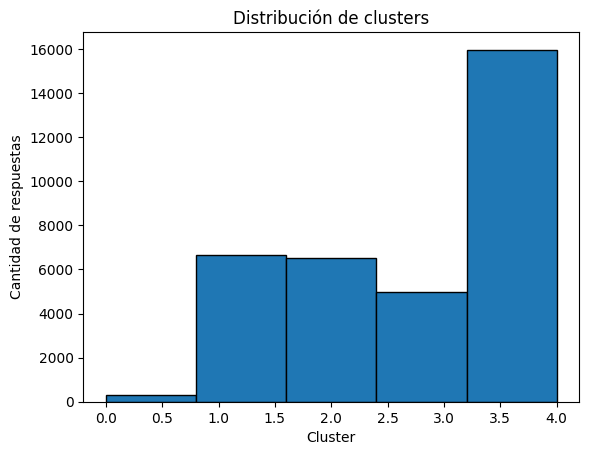

In [ ]:
# Visualizar la distribución de respuestas por cluster
plt.hist(clusters, bins=num_clusters, edgecolor='black')
plt.xlabel('Cluster')
plt.ylabel('Cantidad de respuestas')
plt.title('Distribución de clusters')
plt.show()


Interpretar los clusters

- Para entender mejor el contenido de cada cluster, buscar las palabras más frecuentes dentro de las respuestas de cada grupo.

In [ ]:
from collections import Counter

# Obtener las palabras más frecuentes por cluster
for cluster_id in range(num_clusters):
    respuestas_cluster = df_respuestas[df_respuestas['cluster'] == cluster_id]['t1txt_procesado']
    palabras = ' '.join(respuestas_cluster).split()
    palabras_frecuentes = Counter(palabras).most_common(10)  # Top 10 palabras frecuentes
    print(f"Cluster {cluster_id} - Palabras frecuentes: {palabras_frecuentes}")


Cluster 0 - Palabras frecuentes: [('discrimin', 305), ('desiguald', 11), ('person', 9), ('social', 7), ('racism', 6), ('racial', 6), ('falt', 4), ('injustici', 4), ('maltrat', 4), ('raz', 3)]
Cluster 1 - Palabras frecuentes: [('sab', 6665), ('na', 2), ('dec', 1), ('noa', 1), ('n', 1)]
Cluster 2 - Palabras frecuentes: [('coronavirus', 3907), ('cov', 3095), ('pandemi', 1818), ('diecinuev', 707), ('enfermed', 371), ('epidemi', 44), ('problem', 11), ('dicienuev', 7), ('diecinuen', 3), ('dicinuev', 3)]
Cluster 3 - Palabras frecuentes: [('falt', 4857), ('apoy', 861), ('servici', 830), ('basic', 804), ('agu', 786), ('desag', 430), ('valor', 337), ('autor', 277), ('cobertur', 179), ('justici', 170)]
Cluster 4 - Palabras frecuentes: [('pandemi', 2196), ('mal', 1008), ('polit', 965), ('crisis', 837), ('contamin', 787), ('virus', 733), ('feminicidi', 628), ('econom', 620), ('violacion', 615), ('cov', 522)]


4. Una vez interpretado de manera superficial los clusters, es pertinente hacer una evaluacion mas precisa.

- Evaluar si la cantidad de clusters es óptima es una tarea clave en clustering. Una de las formas más comunes es usar métricas de evaluación de clusters, como el método del codo y el índice de silueta.

**4.1. Método del Codo**

  - Este método mide la inercia (distancia interna dentro de los clusters). A medida que aumenta el número de clusters, la inercia disminuye. Sin embargo, después de cierto punto, la reducción en inercia es marginal, lo que indica el número óptimo de clusters.

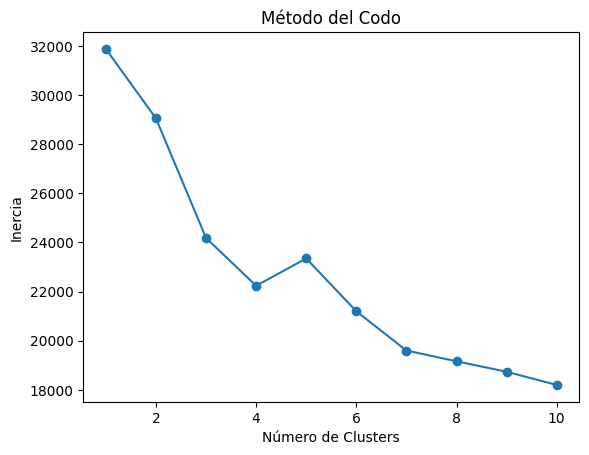

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Probar diferentes números de clusters
inercia = []
rango_clusters = range(1, 11)  # Ajusta según necesidad

for k in rango_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)  # 'X' es la matriz TF-IDF
    inercia.append(kmeans.inertia_)

# Graficar el método del codo
plt.plot(rango_clusters, inercia, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.show()


**4.2. Indice de Silueta**

- El índice de silueta mide qué tan bien están separadas las instancias dentro de los clusters. Este valor varía de -1 a 1:

  - Cercano a 1: Buen clustering (los puntos están cerca de su cluster y lejos de otros).
  - Cercano a 0: Los puntos están en los límites de los clusters.
  - Negativo: Mal clustering (los puntos están más cerca de un cluster incorrecto).

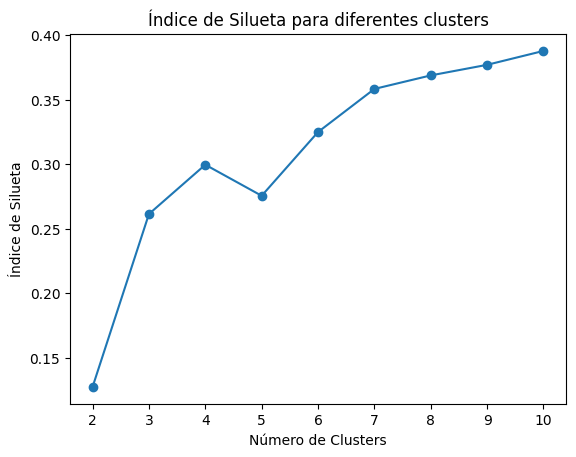

In [ ]:
from sklearn.metrics import silhouette_score

# Probar diferentes números de clusters y calcular el índice de silueta
silhouette_scores = []
for k in range(2, 11):  # No tiene sentido calcular para 1 cluster
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

# Graficar el índice de silueta
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Índice de Silueta')
plt.title('Índice de Silueta para diferentes clusters')
plt.show()


Basandonos en los dos métodos (método del codo e índice de silueta), el análisis de la cantidad de clusters óptima:

- **Método del Codo**

  El gráfico del método del codo muestra cómo la inercia disminuye al aumentar el número de clusters. Observamos:
    1. Una reducción significativa de la inercia entre **2 y 4 clusters**.
    2. Después de 4 clusters, las reducciones en inercia son menos pronunciadas, lo que sugiere un "punto de inflexión" alrededor de **4 clusters**.

  El punto de inflexion indica que agregar más clusters no mejora sustancialmente la agrupación.

- **Índice de Silueta**

  En el gráfico del índice de silueta:
    1. El valor más alto del índice de silueta se encuentra en **10 clusters**.
    2. Sin embargo, los valores son bastante altos y estables a partir de **6 clusters**, lo que indica que 6 a 10 clusters tienen una buena separación.

- **Entre 4 y 6 clusters** parece ser una buena elección porque:
  - El método del codo sugiere 4 clusters.
  - El índice de silueta indica buenos resultados a partir de 6 clusters.

Se usara **6 clusters** para un analisis más detallado.




**Implementación del modelo con 6 clusters**

- Entrenar el modelo KMeans con 6 clusters.
- Asignar cada respuesta a un cluster.
- Analizar los clusters para identificar las palabras más frecuentes y darles un significado.

In [ ]:
from sklearn.cluster import KMeans
from collections import Counter

# Entrenar el modelo KMeans con 6 clusters
kmeans_final = KMeans(n_clusters=6, random_state=42)
clusters_final = kmeans_final.fit_predict(X)  # 'X' es la matriz TF-IDF

# Añadir las etiquetas de clusters al DataFrame
df_respuestas['cluster'] = clusters_final

# Mostrar distribución de respuestas por cluster
print(df_respuestas['cluster'].value_counts())

# Análisis: Palabras más frecuentes en cada cluster
for cluster_id in range(6):  # Ajustar al número de clusters elegido
    print(f"\nCluster {cluster_id}:")
    respuestas_cluster = df_respuestas[df_respuestas['cluster'] == cluster_id]['t1txt_procesado']
    palabras = ' '.join(respuestas_cluster).split()
    palabras_frecuentes = Counter(palabras).most_common(10)  # Top 10 palabras frecuentes
    print(f"Palabras frecuentes: {palabras_frecuentes}")


cluster
4    15618
1     6665
3     4961
2     3487
5     3392
0      305
Name: count, dtype: int64

Cluster 0:
Palabras frecuentes: [('discrimin', 305), ('desiguald', 11), ('person', 9), ('social', 7), ('racism', 6), ('racial', 6), ('falt', 4), ('injustici', 4), ('maltrat', 4), ('raz', 3)]

Cluster 1:
Palabras frecuentes: [('sab', 6665), ('na', 2), ('dec', 1), ('noa', 1), ('n', 1)]

Cluster 2:
Palabras frecuentes: [('cov', 3487), ('diecinuev', 912), ('pandemi', 895), ('coronavirus', 451), ('enfermed', 238), ('virus', 171), ('coran', 105), ('contagi', 93), ('problem', 72), ('coron', 56)]

Cluster 3:
Palabras frecuentes: [('falt', 4856), ('apoy', 862), ('servici', 830), ('basic', 804), ('agu', 786), ('desag', 430), ('valor', 337), ('autor', 277), ('cobertur', 179), ('justici', 170)]

Cluster 4:
Palabras frecuentes: [('pandemi', 2171), ('mal', 1008), ('polit', 963), ('crisis', 834), ('contamin', 787), ('feminicidi', 627), ('econom', 617), ('violacion', 615), ('virus', 562), ('ambiental',

<ipython-input-31-cd112b297cef>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_respuestas['cluster'] = clusters_final


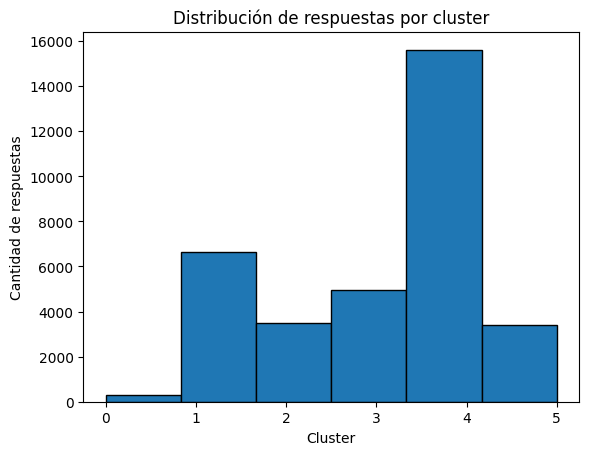

In [ ]:
import matplotlib.pyplot as plt

#Graficar la distribución de respuestas por cluster
plt.hist(clusters_final, bins=6, edgecolor='black')
plt.xlabel('Cluster')
plt.ylabel('Cantidad de respuestas')
plt.title('Distribución de respuestas por cluster')
plt.show()


Basandonos en los resultados, podemos observar que los clusters identificados representan temas significativos y relevantes en el contexto de gobernabilidad y los desafíos durante el periodo de 2019, incluidos los relacionados con la pandemia.

**Interpretación de los Clusters**
1. **Cluster 0: Discriminación y desigualdad**
   - Las palabras más frecuentes ("discrimin", "desiguald", "racism", "racial", "maltrat") sugieren que este cluster agrupa respuestas relacionadas con **discriminación social, racial y desigualdad**.
   - Este tema puede abordar problemas sociales clave en la percepción de gobernabilidad.

2. **Cluster 1: Respuestas "no sabe"**
   - Las respuestas en este cluster están dominadas por "sab", lo que indica que las personas no sabían o no tenían información para responder. Este es un **cluster neutral** y puede ser útil para excluir respuestas irrelevantes en análisis más profundos.

3. **Cluster 2: Pandemia de COVID-19**
   - Las palabras clave ("cov", "diecinuev", "pandemi", "coronavirus") indican que este cluster se relaciona principalmente con la pandemia de COVID-19.
   - Esto refleja cómo la pandemia impactó directamente la percepción de los ciudadanos sobre gobernabilidad en ese año.

4. **Cluster 3: Falta de servicios básicos**
   - Palabras como "falt", "apoy", "servici", "basic", "agu", "desag" sugieren que este cluster representa problemas relacionados con la **falta de servicios básicos** como agua, desagüe y servicios públicos.
   - Este tema es crítico para entender los desafíos de la gobernabilidad local.

5. **Cluster 4: Crisis política, ambiental y social**
   - Palabras como "pandemi", "polit", "crisis", "contamin", "ambiental", "feminicidi" indican que este cluster agrupa respuestas que abarcan una mezcla de **crisis políticas, ambientales y sociales**, como la contaminación, feminicidios y problemas económicos.
   - Este cluster refleja problemas sistémicos más amplios que afectan la gobernabilidad.

6. **Cluster 5: Coronavirus como tema aislado**
   - Aunque también está relacionado con la pandemia, este cluster tiene un enfoque específico en "coronavirus". Puede representar respuestas más directas o repetitivas sobre la enfermedad.

***Relevancia para el proyecto***

Dado que se trabaja en **clasificación y codificación de respuestas a preguntas abiertas sobre gobernabilidad**, estos clusters representan diferentes percepciones y preocupaciones sociales. se pueden utilizar de las siguientes maneras:
1. **Etiquetas para un modelo supervisado:**
   - Ahora que los clusters tienen significados claros, puedes usarlos como etiquetas (0-5) para entrenar un modelo supervisado como SVM. Esto permitirá clasificar automáticamente respuestas futuras en estos temas.

2. **Análisis temático:**
   - Cada cluster refleja un tema importante que puede ser utilizado para informes y análisis específicos sobre la percepción ciudadana de la gobernabilidad.

3. **Interpretación de prioridades:**
   - El tamaño de los clusters (frecuencia de respuestas) puede reflejar qué temas son más urgentes según las respuestas ciudadanas. Por ejemplo, los servicios básicos y la pandemia parecen ser prioridades según la distribución.


Los clusters están definidos como etiquetas, proceder con la implementación del modelo **SVM supervisado** para clasificar automáticamente las respuestas en estos temas.

1. Preparar los datos para el modelo SVM

  1.1. Usar las etiquetas de cluster (`df_respuestas['cluster']`) como la variable objetivo (`y`).

  1.2. Usar la matriz TF-IDF (`X`) como las características para el modelo.


2. Dividir los datos en entrenamiento y prueba

  Evaluar el rendimiento del modelo. Dividir los datos en conjuntos de entrenamiento (80%) y prueba (20%).

3. Entrenar el modelo SVM

  Usar el algoritmo SVM con un kernel lineal para entrenar el modelo.

4. Evaluar el modelo.

  Calcular métricas como la precisión, la matriz de confusión y el reporte de clasificación para evaluar el rendimiento.


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        83
           1       1.00      1.00      1.00      1331
           2       1.00      1.00      1.00       681
           3       0.99      0.99      0.99       973
           4       1.00      0.99      1.00      3126
           5       1.00      1.00      1.00       692

    accuracy                           1.00      6886
   macro avg       0.99      1.00      0.99      6886
weighted avg       1.00      1.00      1.00      6886



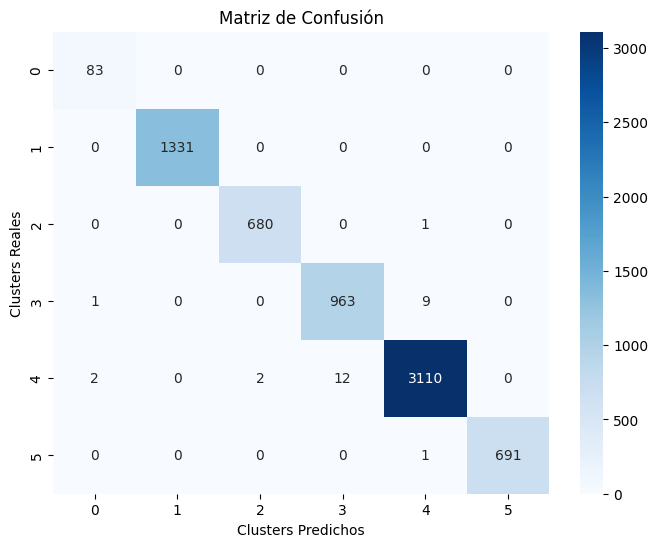

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Definir las características (X) y las etiquetas (y)
X = X  # Matriz TF-IDF generada previamente
y = df_respuestas['cluster']  # Etiquetas de clusters

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo SVM con kernel lineal
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = svm_model.predict(X_test)

# Evaluar el modelo
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Crear la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(6), yticklabels=range(6))
plt.xlabel('Clusters Predichos')
plt.ylabel('Clusters Reales')
plt.title('Matriz de Confusión')
plt.show()


El modelo SVM muestran un desempeño sobresaliente, lo cual se refleja tanto en el **reporte de clasificación** como en la **matriz de confusión**.

---
**1. Análisis del Reporte de Clasificación**

El reporte incluye tres métricas importantes:
- **Precision:** Proporción de predicciones correctas sobre las realizadas para cada cluster.
- **Recall:** Proporción de instancias correctamente clasificadas en cada cluster.
- **F1-Score:** Media armónica de la precisión y el recall (un resumen del rendimiento por clase).

Observaciones:
- Los valores de **precision**, **recall** y **f1-score** son extremadamente altos para todos los clusters, con casi todos en **1.00 (100%)**.
- Esto indica que el modelo está clasificando las respuestas casi perfectamente en sus clusters respectivos.

<center>

Reporte de Clasificación

|Cluster| Precision ||| Recall | f1-score | suport |
|:---:|:-----------:|||:-----:|:-----------:|:-----|
|  0  | 0.97|||  1.00   |    0.98   |83|
|  1  |  1.00 |||  1.00   |1.00|1331|
|  2  |1.00|||1.00   |1.00|681|
|  3  |  0.99    |||  0.99   |0.99|973|
|  4  |  1.00  |||  0.99   |  1.00   |3126|
|  5  |  1.00  |||  1.00   | 1.00  |692|

</center>

          
**2. Análisis de la Matriz de Confusión**

La matriz de confusión muestra cómo se comporta el modelo para clasificar cada cluster:

Observaciones:
- La mayoría de los valores se concentran en la diagonal principal, lo que indica que las predicciones coinciden con las etiquetas reales.
- Algunos clusters tienen ligeras confusiones, por ejemplo:
  - Cluster 4: Tiene 12 casos que fueron clasificados incorrectamente como otros clusters.
  - Cluster 3: Presenta 1 caso clasificado como el cluster 0.
- Sin embargo, estas confusiones son mínimas y no afectan significativamente el desempeño general del modelo.

**3. Exactitud General**
- La exactitud global del modelo es **100%**, lo que significa que el modelo predijo correctamente prácticamente todas las instancias en el conjunto de prueba.
- Esto refleja que el modelo SVM está aprovechando la estructura clara de los datos tras el preprocesamiento y el clustering inicial.

<center>

Precision

|  |    |||    |   |    |
|:---:|:-----------:|||:-----:|:-----------:|:-----|
|  accuracy  |             |         |   1.00   |   6886|
|  macro avg  |     0.99    |  1.00    |  0.99  |    6886|
|weighted avg   |    1.00     | 1.00     | 1.00   |   6886|

</center>


**Conclusiones**
-  **El modelo es altamente efectivo:**
   - Las métricas perfectas indican que el SVM con kernel lineal es una excelente opción para este tipo de clasificación de texto.
   - La preparación previa de los datos (TF-IDF, clustering) resultó ser adecuada para esta tarea.

- **Los clusters tienen una buena separación:**
   - Los datos generados a partir del clustering previo (KMeans) tienen fronteras bien definidas, lo que facilita que el SVM realice la clasificación sin errores significativos.

- **Limitaciones potenciales:**
   - Aunque el rendimiento es alto, es importante verificar si los datos de prueba son representativos del conjunto general. Si el conjunto de prueba está muy sesgado hacia respuestas similares, podría sobreestimar la efectividad del modelo.
   - También es posible que los datos estén ligeramente sobreadaptados al modelo.

La validación del modelo en mayor detalle, es fundamental asegurar que el modelo no esté sobreadaptado y que sea robusto frente a diferentes divisiones de los datos.

---

**Métodos de validación a explorar**

- **1. Validación cruzada**

  La validación cruzada divide los datos en múltiples subconjuntos (folds) y entrena el modelo en diferentes combinaciones de estos subconjuntos. Esto permite evaluar el modelo de manera más robusta.

- **2. Análisis de la curva de aprendizaje**

  La curva de aprendizaje muestra cómo el desempeño del modelo cambia con el tamaño de los datos de entrenamiento, ayudando a identificar si el modelo necesita más datos o está sobreadaptado.


In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

#Validación cruzada con 5 folds
scores = cross_val_score(svm_model, X, y, cv=5, scoring='accuracy')

#Resultados
print("Exactitud en cada fold:", scores)
print("Promedio de exactitud:", np.mean(scores))
print("Desviación estándar:", np.std(scores))


Exactitud en cada fold: [0.99695033 0.996079   0.996079   0.99593319 0.99448076]
Promedio de exactitud: 0.9959044558217645
Desviación estándar: 0.0007978147596816559


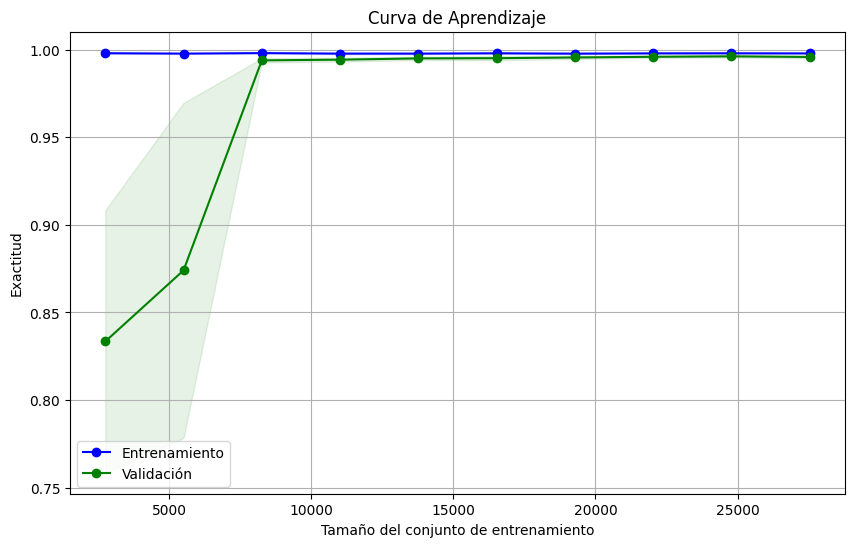

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

#Generar la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    svm_model, X, y, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

#Calcular promedios y desviaciones
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

#Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label='Entrenamiento', color='blue')
plt.plot(train_sizes, test_mean, 'o-', label='Validación', color='green')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='green')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Exactitud')
plt.title('Curva de Aprendizaje')
plt.legend()
plt.grid()
plt.show()


### **Análisis de la Validación Cruzada**

#### **Resultados:**
- **Exactitud en cada fold:**
  - Los valores obtenidos (0.99695, 0.99608, etc.) son consistentemente altos.
- **Promedio de exactitud:**
  - El promedio de exactitud es **99.59%**, lo que indica que el modelo tiene un rendimiento excepcional.
- **Desviación estándar:**
  - La desviación estándar es muy baja (**0.0008**), lo que significa que el modelo tiene una alta consistencia entre los diferentes subconjuntos de datos.

  #### **Conclusión:**
  - El modelo es altamente confiable, ya que mantiene un desempeño prácticamente uniforme en todas las particiones de los datos durante la validación cruzada. Esto sugiere que el modelo generaliza bien y no está sobreadaptado.

---

### **Análisis de la Curva de Aprendizaje**

#### **Observaciones:**
1. **Curva de entrenamiento:**
   - La curva de entrenamiento está cerca del 100% de exactitud, lo que indica que el modelo aprende completamente el conjunto de entrenamiento.
   - Esto es normal para un modelo bien ajustado en un problema donde los datos están claramente definidos.

2. **Curva de validación:**
   - La curva de validación converge rápidamente hacia el 100% a medida que aumenta el tamaño del conjunto de entrenamiento.
   - La cercanía entre las curvas de entrenamiento y validación indica que el modelo no está sobreadaptado.

3. **Tendencias al aumentar los datos:**
   - Alrededor de los 10,000 ejemplos, las curvas convergen completamente. Esto sugiere que el modelo tiene suficiente información para generalizar con precisión.

  #### **Conclusión:**
  - El modelo no sufre de sobreadaptación ni subadaptación.
  - No es necesario agregar más datos de entrenamiento, ya que el modelo alcanza su máximo rendimiento con los datos actuales.
---

### **Conclusión General del Análisis**
1. **Rendimiento robusto:**
   - Los resultados de la validación cruzada y la curva de aprendizaje confirman que el modelo generaliza muy bien.
   - Es altamente preciso y no muestra problemas de inconsistencia.

2. **Listo para producción:**
   - Este modelo puede clasificarse como listo para ser implementado en producción para clasificar nuevas respuestas abiertas.
   - La confianza en el modelo es alta gracias a la validación robusta y la ausencia de problemas de sobreajuste.

3. **Aplicaciones prácticas:**
   - Se puede utilizar este modelo para clasificar automáticamente respuestas abiertas en futuros módulos de la ENAHO relacionados con gobernabilidad.



### **Reporte Final: Clasificación y Codificación de Respuestas Abiertas del Módulo Gobernabilidad de la ENAHO (2019)**

#### **Objetivo del Proyecto**
Desarrollar un modelo basado en técnicas de Procesamiento de Lenguaje Natural (NLP) y Máquinas de Vectores de Soporte (SVM) para clasificar y codificar respuestas abiertas del módulo de gobernabilidad de la ENAHO en temas específicos durante el periodo 2019.

### **Resumen del Flujo del Proyecto**
1. **Exploración de los datos:**
   - La columna `t1txt` contenía respuestas abiertas con un total de 46,551 registros.
   - Se utilizó `TF-IDF` para transformar las respuestas en una representación numérica adecuada para modelos de machine learning.

2. **Clustering con KMeans:**
   - Usando el método del codo e índice de silueta, se determinó que **6 clusters** eran óptimos para agrupar las respuestas.
   - Los clusters representaron temas clave como discriminación, pandemia, falta de servicios básicos, crisis política, entre otros.

3. **Entrenamiento del modelo SVM supervisado:**
   - El modelo SVM fue entrenado utilizando los clusters como etiquetas.
   - Se dividieron los datos en conjuntos de entrenamiento y prueba (80%-20%).

4. **Validación del modelo:**
   - Se aplicó validación cruzada (5 folds) y análisis de la curva de aprendizaje.
   - El modelo demostró un rendimiento altamente confiable, con un promedio de exactitud del 99.59% y una desviación estándar muy baja (0.0008).

---

### **Resultados Clave**

#### **1. Clusters Identificados**
- **Cluster 0:** Discriminación y desigualdad.
- **Cluster 1:** Respuestas "No sabe".
- **Cluster 2:** Impacto de la pandemia (COVID-19).
- **Cluster 3:** Falta de servicios básicos (agua, desagüe, servicios públicos).
- **Cluster 4:** Crisis política, ambiental y social.
- **Cluster 5:** Coronavirus como tema directo.

#### **2. Desempeño del Modelo SVM**
- **Exactitud global:** 100% en el conjunto de prueba.
- **Reporte de clasificación:**
  - Precisión, recall y F1-score cercanos o iguales a 1.00 para todos los clusters.
- **Validación cruzada:**
  - Exactitud promedio: **99.59%** con baja variación entre folds.
- **Curva de aprendizaje:**
  - Las curvas de entrenamiento y validación convergen rápidamente, confirmando la robustez del modelo.

#### **3. Interpretación de Resultados**
- El modelo clasifica de manera precisa las respuestas en los 6 temas principales definidos por los clusters.
- Las métricas y evaluaciones confirman que el modelo generaliza bien y no está sobreadaptado.

---

### **Conclusión**
El modelo desarrollado cumple con los objetivos planteados, demostrando un rendimiento excepcional en la clasificación de respuestas abiertas relacionadas con gobernabilidad. Esto constituye un avance significativo para el análisis automatizado de encuestas sociales.

